**Inteligência Artificial**

**812839 - Vinícius Miranda de Araújo**

**Lista 03**

---
---

### **Questão 1**

---



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import tree

# Ler o arquivo de treino
training_data = pd.read_csv( 'titanic/train.csv' )
# Ler o arquivo de teste
test_data = pd.read_csv( 'titanic/test.csv' )
# Ler o arquivo com a resposta correta do o conjunto de teste
truth_table = pd.read_csv( 'titanic/gender_submission.csv' )

# Adicionar coluna 'Survived' ao test_data
test_data = test_data.merge(truth_table, on='PassengerId', how='left')

# ------------------------------------
# --- Pre-processamentos de Dados
# ------------------------------------

# Remover colunas irrelevantes ou com muitos valores ausentes
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked']

# Transformação de dados categóricos
encoder = LabelEncoder()
training_data['Sex'] = encoder.fit_transform( training_data['Sex'] )
test_data['Sex']     = encoder.transform( test_data['Sex'] )

# Preenchendo valores ausentes
training_data['Age'] = training_data['Age'].fillna( training_data['Age'].median( ) )
test_data['Age']     = test_data['Age'].fillna( test_data['Age'].median( ) )

training_data['Fare'] = training_data['Fare'].fillna( training_data['Fare'].median( ) )
test_data['Fare']     = test_data['Fare'].fillna( test_data['Fare'].median( ) )

# Separar variáveis independentes e dependentes
X_treino = training_data.drop( columns = columns_to_drop + ['Survived'], axis = 1 ) # X_treino = colunas de treino
y_treino = training_data['Survived']                                                # y_treino = coluna de resposta

X_teste  = test_data.drop( columns = columns_to_drop + ['Survived'], axis = 1  )    # X_teste = colunas de teste
y_teste  = test_data['Survived']                                                    # y_teste = coluna de resposta

# ------------------------------------
# --- Descobrir melhores hiperparâmetros
# ------------------------------------

# Definição de hiperparâmetros para Decision Tree
params = {
    'criterion'        : ['gini', 'entropy'],
    'max_depth'        : [2, 3, 4],
    'max_features'     : ['sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'min_samples_split': [20, 30, 40, 50]
}

# Encontrar melhores hiperparâmetros
modelo = GridSearchCV(
    estimator  = DecisionTreeClassifier( ),
    param_grid = params,
    cv         = 10,
    n_jobs     = 5,
    verbose    = 1,
)

# Treina o modelo com os dados de treino (X_treino e y_treino)
modelo.fit( X_treino, y_treino )
print( "Melhores hiperparâmetros..:", modelo.best_params_ )
print( "Melhor pontuação..........:", modelo.best_score_ )

# ------------------------------------
# --- Treinar o Modelo
# ------------------------------------

# Treinar modelo de gini com os melhores hiperparâmetros
modelo_gini = DecisionTreeClassifier(
    criterion         = 'gini',
    max_depth         = modelo.best_params_['max_depth'],
    max_features      = modelo.best_params_['max_features'],
    min_samples_split = modelo.best_params_['min_samples_split'],
    random_state      = 42
)
modelo_gini.fit( X_treino, y_treino )

# Treinar modelo de entropia com os melhores hiperparâmetros
modelo_entropia = DecisionTreeClassifier(
    criterion         = 'entropy',
    max_depth         = modelo.best_params_['max_depth'],
    max_features      = modelo.best_params_['max_features'],
    min_samples_split = modelo.best_params_['min_samples_split'],
    random_state      = 42
)
modelo_entropia.fit( X_treino, y_treino )

# ------------------------------------
# --- Testar e Avaliar o Modelo
# ------------------------------------

# Fazer previsões
y_pred_gini     = modelo_gini.predict( X_teste )
y_pred_entropia = modelo_entropia.predict( X_teste )

# Avaliar o modelo
print( "Acurácia do modelo - Gini............:", accuracy_score( y_teste, y_pred_gini ) )
print( "Matriz de Confusão - Gini............:\n", confusion_matrix( y_teste, y_pred_gini ) )
print( "Relatório de Classificação - Gini....:\n", classification_report( y_teste, y_pred_gini ) )

print( "Acurácia do modelo - Entropia........:", accuracy_score( y_teste, y_pred_entropia ) )
print( "Matriz de Confusão - Entropia........:\n", confusion_matrix( y_teste, y_pred_entropia ) )
print( "Relatório de Classificação - Entropia:\n", classification_report( y_teste, y_pred_entropia ) )

# Matriz de Confusão
def plot_confusion_matrix( y_true, y_pred, title ):
    cm = confusion_matrix( y_true, y_pred )
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['Não Sobreviveu', 'Sobreviveu'],
        yticklabels=['Não Sobreviveu', 'Sobreviveu']
    )
    plt.xlabel( 'Previsto' )
    plt.ylabel( 'Real' )
    plt.title( title )
    plt.show( )

plot_confusion_matrix( y_teste, y_pred_gini, "Matriz de Confusão - Gini" )
plot_confusion_matrix( y_teste, y_pred_entropia, "Matriz de Confusão - Entropia" )

# Árvores de Decisão
def plot_decision_tree( modelo, title ):
    plt.figure( figsize=(15, 10) )
    tree.plot_tree(
        modelo,
        feature_names = X_treino.columns,
        class_names   = ['Não Sobreviveu', 'Sobreviveu'],
        filled        = True,
        rounded       = True
    )
    plt.title( title )
    plt.show( )

plot_decision_tree( modelo_gini, "Árvore de Decisão - Critério Gini" )
plot_decision_tree( modelo_entropia, "Árvore de Decisão - Critério Entropy" )

# Importância das features
def plot_feature_importance( modelo, X_treino ):
    importancias = modelo.feature_importances_
    features     = pd.DataFrame( {'Feature': X_treino.columns, 'Importância': importancias} )
    features     = features.sort_values( by='Importância', ascending=False )
    return features

print( "Importância das Features - Gini" )
print( plot_feature_importance( modelo_gini, X_treino ) )

print( "\nImportância das Features - Entropia" )
print( plot_feature_importance( modelo_entropia, X_treino ) )

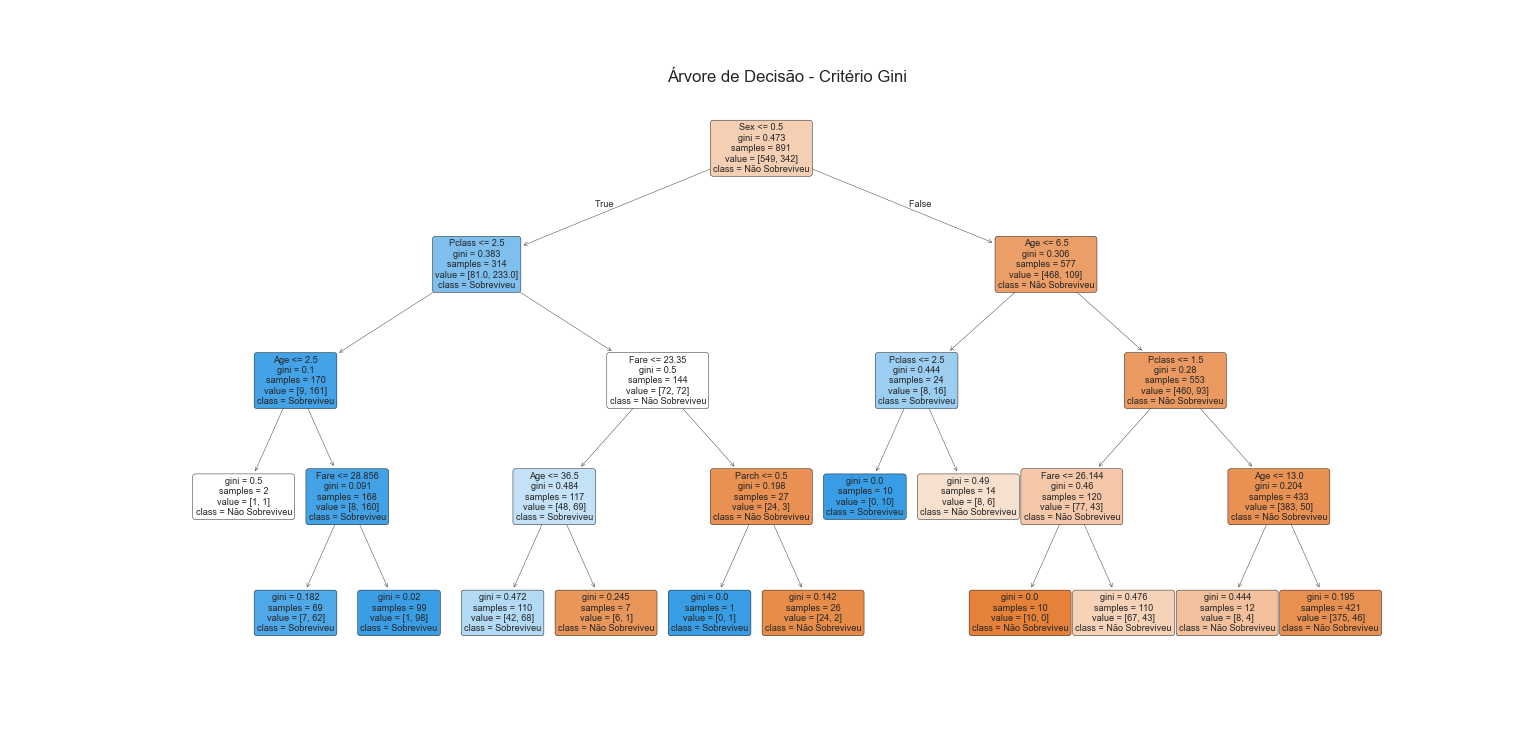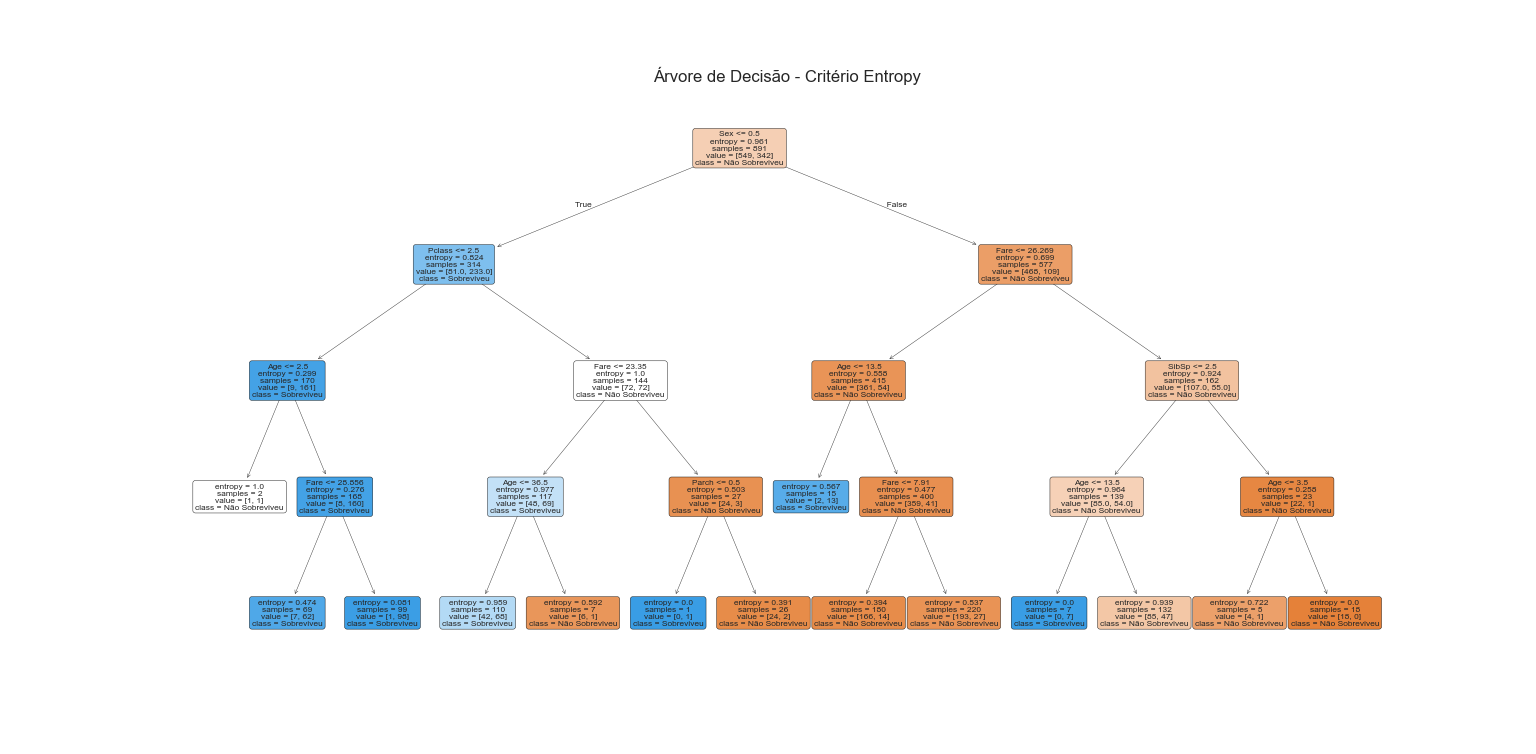

**Importância dos Atributos**

Gini

|   | Feature | Importância |
|---|---------|-------------|
| 1 |     Sex |   0.615847  |
| 0 |  Pclass |   0.227955  |
| 2 |     Age |   0.081102  |
| 5 |    Fare |   0.066973  |
| 4 |   Parch |   0.008122  |
| 3 |   SibSp |   0.000000  |

Entropia

|   | Feature | Importância |
|---|---------|-------------|
| 1 |     Sex |    0.526768 |
| 0 |  Pclass |    0.173398 |
| 2 |     Age |    0.139928 |
| 5 |    Fare |    0.123904 |
| 3 |   SibSp |    0.026724 |
| 4 |   Parch |    0.009278 |

**Explicação dos Critérios Gini e Entropy:**

1. Critério Gini: Mede a impureza de um nó na árvore de decisão. O cálculo é feito com:
   
   Gini = 1 - ∑ pi^2
   
   >pi é a proporção de amostras pertencentes a uma classe no nó.

2. Critério Entropy: Mede a desordem da distribuição das classes em um nó. O cálculo é feito com:
   
   Entropy = - ∑ pi*log(pi, 2)
   
**Comparação:**

- Gini tende a criar divisões mais puras em cada nó.
- Entropy é mais sensível a mudanças pequenas nos dados.
- Em geral, as diferenças entre ambos são pequenas, mas o Gini pode ser ligeiramente mais rápido.

### **Questão 2**

---

A Árvore de Decisão pode ser ajustada através de diversos hiperparâmetros que afetam diretamente sua complexidade e capacidade de generalização.

### 1. `max_depth` (Profundidade Máxima)
- Define a profundidade máxima da árvore.
- Impacto:
  - Muito alta → Overfitting (árvore complexa, aprende ruído dos dados).
  - Muito baixa → Underfitting (modelo muito simples, perde padrões importantes).

### 2. `max_features` (Número Máximo de Atributos por Divisão)
- Define quantos atributos serão considerados na escolha da melhor divisão.
- Valores possíveis:
  - `"sqrt"` → Raiz quadrada do número de atributos.
  - `"log2"` → Logaritmo base 2 do número de atributos.
  - `None` → Usa todos os atributos.
  - Frações (`0.2, 0.4, 0.6, 0.8`) → Usa essa proporção do total de atributos.
- Impacto:
  - Valor alto → Overfitting (pode explorar padrões irrelevantes).
  - Valor baixo → Mais generalização, pode melhorar desempenho.


### 3. `min_samples_split` (Mínimo de Amostras para Divisão)
- Número mínimo de amostras necessário para dividir um nó.
- Impacto:
  - Valor baixo (`2, 5`) → Cria muitas divisões, aumentando a complexidade.
  - Valor alto (`20, 50`) → Garante que cada nó tenha dados suficientes, reduzindo overfitting.


### 4. `min_samples_leaf` (Mínimo de Amostras por Folha)
- Define o número mínimo de amostras que um nó folha pode ter.
- Impacto:
  - Baixo (`1, 5`) → Modelo mais detalhado, mas pode sofrer overfitting.
  - Alto (`10, 20`) → Árvore mais generalizada, melhor para evitar overfitting.


### 5. `criterion` (`gini` vs `entropy`)
- Define a métrica para medir a impureza dos nós.
- Discussão: O `gini` é mais rápido computacionalmente, enquanto `entropy` pode gerar divisões mais informativas.


### 6. `max_leaf_nodes` (Máximo de Nós Folha)
- Limita o número máximo de folhas na árvore.
- Impacto:
  - Menos folhas → Árvore mais simples, generaliza melhor.
  - Mais folhas → Pode sofrer overfitting.


In [ ]:
# Definição de hiperparâmetros para Otimizador
params = {
    'criterion'        : ['gini', 'entropy'],
    'max_depth'        : [None, 2, 4, 6, 8, 10],
    'max_features'     : [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf' : [1, 5, 10, 20],
    'max_leaf_nodes'   : [None, 5, 10, 20, 50]
}

### **Questão 3**

---

1. **GridSearchCV:** Faz uma busca exaustiva testando todas as combinações
possíveis dos hiperparâmetros especificados. Garante encontrar a melhor configuração, mas pode ser computacionalmente caro.

2. **RandomizedSearchCV:** Amostra aleatoriamente um subconjunto de combinações possíveis, reduzindo o custo computacional, mas sem a garantia de encontrar a melhor configuração absoluta.

3. **BayesSearchCV:** Utiliza otimização Bayesiana para escolher inteligentemente os hiperparâmetros a serem testados com base nos resultados anteriores, balanceando precisão e eficiência.

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV

# Ler o arquivo de treino
training_data = pd.read_csv( 'titanic/train.csv' )

# ------------------------------------
# --- Pre-processamentos de Dados
# ------------------------------------

# Remover colunas irrelevantes ou com muitos valores ausentes
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked']

# Transformação de dados categóricos
encoder = LabelEncoder()
training_data['Sex'] = encoder.fit_transform( training_data['Sex'] )

# Preenchendo valores ausentes
training_data['Age'] = training_data['Age'].fillna( training_data['Age'].median( ) )

training_data['Fare'] = training_data['Fare'].fillna( training_data['Fare'].median( ) )

# Separar variáveis independentes e dependentes
X_treino = training_data.drop( columns = columns_to_drop + ['Survived'], axis = 1 ) # X_treino = colunas de treino
y_treino = training_data['Survived']                                                # y_treino = coluna de resposta

# ------------------------------------
# --- Otimização de Hiperparâmetros
# ------------------------------------

# Definição de hiperparâmetros para Otimizador de HIPERPARÂMETROS
params = {
    'criterion'        : ['gini', 'entropy'],
    'max_depth'        : [None, 2, 4, 6, 8, 10],
    'max_features'     : [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf' : [1, 5, 10, 20],
    'max_leaf_nodes'   : [None, 5, 10, 20, 50]
}

# GridSearchCV para otimização
grid_search = GridSearchCV(
    estimator  = DecisionTreeClassifier( ),  # Modelo de Classificação
    param_grid = params,                     # Dicionário de Hiperparâmetros
    cv         = 10,                         # Cross-Validation (número de divisões para validação cruzada)
    n_jobs     = 1,                          # Número de Processos Paralelos
    verbose    = 1                           # Exibir detalhes da execução
)
grid_search.fit( X_treino, y_treino )

print( "Melhores parâmetros (GridSearchCV)......:", grid_search.best_params_ )
print( "Acurácia (GridSearchCV).................:", grid_search.best_score_ )

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    DecisionTreeClassifier( ),     # Modelo de Classificação
    param_distributions = params,  # Dicionário de Hiperparâmetros
    cv                  = 10,      # Cross-Validation (número de divisões para validação cruzada)
    n_jobs              = 1,       # Número de Processos Paralelos
    verbose             = 1        # Exibir detalhes da execução
)
random_search.fit( X_treino, y_treino )

print( "Melhores parâmetros (RandomizedSearchCV):", random_search.best_params_ )
print( "Acurácia (RandomizedSearchCV)...........:", random_search.best_score_ )

# BayesSearchCV
bayes_search = BayesSearchCV(
    DecisionTreeClassifier( ),   # Modelo de Classificação
    search_spaces= params,       # Dicionário de Hiperparâmetros
    cv           = 5,            # Cross-Validation (número de divisões para validação cruzada)
    n_jobs       = 1,            # Número de Processos Paralelos
    verbose      = 1             # Exibir detalhes da execução
)
bayes_search.fit( X_treino, y_treino )

print( "Melhores parâmetros (BayesSearchCV).....:", bayes_search.best_params_ )
print( "Acurácia (BayesSearchCV)................:", bayes_search.best_score_ )

### **Questão 4**

---

Considere um modelo de classificação binária que identifica fraudes em transações financeiras. Suponha que a base de dados tenha um número significativamente maior de transações legítimas do que fraudulentas. Com base nas métricas de avaliação precisão (precision), revocação (recall) e F1-score, analise as seguintes afirmações:

**I.** Se o modelo tem alta precisão, isso significa que a maioria das transações classificadas como fraudulentas realmente são fraudes, mas pode estar deixando muitas fraudes reais passarem despercebidas.

**II.** Se o modelo tem alta revocação, isso significa que ele consegue identificar quase todas as fraudes, mas pode incluir muitas transações legítimas como fraudulentas.

**III.** O F1-score é útil quando há um grande desequilíbrio entre classes, pois equilibra precisão e revocação, sendo sempre a média aritmética dessas métricas.

Qual das alternativas abaixo é correta?

A) Apenas I e II

B) Apenas II e III

C) Apenas I e III

D) I, II e III

>**Resposta: Letra A**

### **Questão 5**

---

Um modelo de diagnóstico de doenças raras foi desenvolvido para identificar pacientes infectados com uma condição grave. Com base nas métricas precisão (precision) e revocação (recall), analise as seguintes afirmações:

**I.** Se a revocação for aumentada, mais casos reais da doença serão detectados, mas isso pode aumentar os falsos positivos, reduzindo a precisão.

**II.** Se um modelo tem alta precisão, isso significa que a maioria dos pacientes diagnosticados como positivos realmente tem a doença, mas isso não garante que todos os doentes tenham sido identificados.

**III.** Para um diagnóstico de doenças altamente letais, um modelo com alta precisão sempre é preferível a um modelo com alta revocação, pois evita alarmes falsos e diagnósticos errados.

Qual das alternativas abaixo é correta?

A) Apenas I e II

B) Apenas I e III

C) Apenas II e III

D) I, II e III

>**Resposta: Letra A**

### **Questão 6**

---

**ID3**

- Utiliza exclusivamente a entropia e o ganho de informação para escolher os atributos que farão a separação dos dados.
- Ignora exemplos que contêm valores ausentes, o que pode reduzir a quantidade de dados disponíveis para a aprendizagem.
- Só funciona com atributos categóricos.
- Não realiza poda após a construção da árvore, o que pode gerar sobreajuste aos dados de treinamento.
- Pode gerar árvores com múltiplos ramos por nó (se um atributo tiver 10 valores, pode gerar 10 ramos).


**C4.5**

- Introduz o ganho de informação normalizado (ou razão de ganho), que reduz o viés do ID3 em favorecer atributos com muitos valores distintos.
- Permite valores ausentes ao calcular probabilidades para cada possível valor de um atributo ausente.
- Suporta atributos contínuos, determinando automaticamente pontos de corte para dividir os valores numéricos em faixas.
- Aplica poda pós-poda (post-pruning) para reduzir o tamanho da árvore e melhorar a generalização.
- Embora suporte múltiplos ramos, pode converter a árvore em um formato binário para simplificar sua estrutura.

>**Resumo**
>
>| Característica          | ID3                 | C4.5                       |
>|-------------------------|---------------------|----------------------------|
>| **Critério de Escolha** | Ganho de Informação | Razão de Ganho             |
>| **Atributos Numéricos** | Não suporta         | Suporta e define pontos de corte  |
>| **Valores Ausentes**    | Ignora os exemplos  | Trabalha com probabilidades |
>| **Poda**                | Não realiza         | Aplica poda pós-construção  |
>| **Estrutura da Árvore** | Multifurcada        | Pode converter em binária   |



### **Questão 7**

---

A principal diferença entre as duas métricas é que o ganho de informação favorece atributos com muitos valores, enquanto a razão de ganho normaliza essa métrica, penalizando divisões complexas, e é, portanto, mais equilibrada na escolha dos atributos.